<a href="https://colab.research.google.com/github/fernanda-palacios/ai-code-notebooks/blob/main/h_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Defining Functions

In [ ]:
import torch
import torchvision

from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(64)


def train(dataset, loader, model, criterion, optimizer, epochs=10,
          compare_targets=False, noise=0.):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)
    model = model.to(device)
    model.train()

    for epoch in range(epochs):
        full_loss = 0.0

        for images, targets in tqdm(loader):
            images = images.to(device)

            optimizer.zero_grad()

            if noise > 0:
                reconstructed = model(images + noise * torch.randn_like(images))
            else:
                reconstructed = model(images)

            if compare_targets:
                targets = targets.to(device)
                loss = criterion(reconstructed, targets.to(torch.float))
            else:
                loss = criterion(reconstructed, images)

            loss.backward()
            optimizer.step()

            full_loss += loss.item() * len(images)
        average_loss = full_loss / len(dataset)
        print(f"Epoch {epoch+1} training average loss: {average_loss:.3f}")


def image_grid(images):
    grid = torchvision.utils.make_grid(images.cpu())
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()


def test(data_iter, model, noise=0.):
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    if noise > 0:
        images = images + noise * torch.randn_like(images)

    model.eval()
    with torch.no_grad():
        reconstructions = model(images)

    image_grid(images)
    image_grid(reconstructions)

## MNIST

In [ ]:
MNIST_preprocess = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(0.1307, 0.3081)])

MNIST_train_set = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform = MNIST_preprocess)
MNIST_test_set = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform = MNIST_preprocess)

100%|██████████| 9912422/9912422 [00:00<00:00, 109307937.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 101880314.40it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28920448.27it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14421293.54it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Fully connected autoencoder
class MNISTAuto(nn.Module):

    def __init__(self, latent_dims):
        super(MNISTAuto, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(28*28, 128), nn.ReLU(),
            nn.Linear(128, 50), nn.ReLU(),
            nn.Linear(50, latent_dims)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 50), nn.ReLU(),
            nn.Linear(50, 128), nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
MNIST_train_loader = torch.utils.data.DataLoader(
    MNIST_train_set, batch_size=64, shuffle=True)
MNIST_project = MNISTAuto(2) #to be able to plot the latent space in 2 dimensions

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(MNIST_project.parameters(), lr=0.001)
train(MNIST_train_set, MNIST_train_loader, MNIST_project, criterion, optimizer)

Device: cuda:0


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1 training average loss: 0.538


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2 training average loss: 0.469


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3 training average loss: 0.449


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4 training average loss: 0.438


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5 training average loss: 0.429


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6 training average loss: 0.422


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7 training average loss: 0.417


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8 training average loss: 0.413


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9 training average loss: 0.411


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10 training average loss: 0.407


In [ ]:
# Principal Component Analysis. Proejct datapoints into hyperplane. Clustering
from torch.utils.tensorboard.writer import SummaryWriter
board = SummaryWriter()
all_test_loader = torch.utils.data.DataLoader(MNIST_test_set, 10000)
all_test = iter(all_test_loader)
images, labels = next(all_test)
board.add_embedding(images.flatten(1), metadata = labels)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

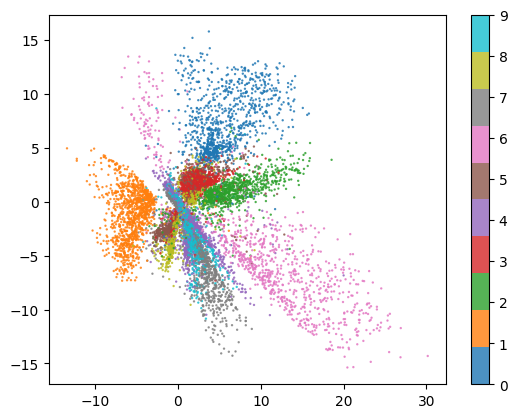

In [ ]:
# Autoenconder, neural network.Clustering
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MNIST_project.eval()
with torch.no_grad():
    codes = MNIST_project.encoder(images.to(device))

scatter_plot = plt.scatter(
    codes[:, 0].cpu(), codes[:, 1].cpu(),
    c = labels, cmap='tab10', s=0.5, alpha=0.8)
plt.colorbar(scatter_plot)
plt.show()

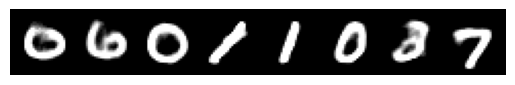

In [ ]:
# Sample from latent space to produce new images (that weren't on the dataset)
sampled = torch.Tensor(8, 2).uniform_(-10, 10).to(device)
with torch.no_grad():
    generated = MNIST_project.decoder(sampled)
image_grid(generated.cpu())

In [ ]:
from random import choice

# Linearly change from one datapoint to another one (traversing the manifold)

def linear_interpolate(first, second, model):
    digits = torch.stack((first, second))
    model.eval()

    with torch.no_grad():
        code_1, code_2 = model.encoder(digits)

    inputs_range = torch.arange(0, 1.1, 1/7).view(-1, 1, 1).to(device)
    codes_range = torch.arange(0, 1.1, 1/7).unsqueeze(1).to(device)

    between_inputs = second * inputs_range + first * (1-inputs_range)
    between_codes = code_2 * codes_range + code_1 * (1-codes_range)

    image_grid(between_inputs.unsqueeze(1))
    image_grid(model.decoder(between_codes))


sample_test_loader = torch.utils.data.DataLoader(MNIST_test_set, 1000)
sample_test_iter = iter(sample_test_loader)
sample_images, sample_labels = next(sample_test_iter)
digits_map = {}
for digit in range(10):
    digits_map[digit] = torch.where(sample_labels == digit)[0].tolist()

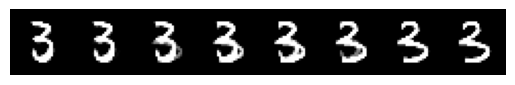

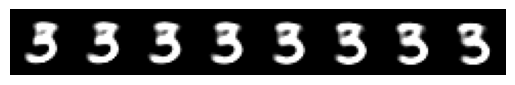

In [ ]:
first_digit = sample_images[choice(digits_map[3])].to(device)
second_digit = sample_images[choice(digits_map[3])].to(device)
linear_interpolate(first_digit, second_digit, MNIST_project)

In [ ]:
# Denoising images
MNIST_denoise = MNISTAuto(10)
optimizer = torch.optim.Adam(MNIST_denoise.parameters(), lr=0.001)
train(MNIST_train_set, MNIST_train_loader, MNIST_denoise,
      criterion, optimizer, noise=2)

MNIST_test_loader = torch.utils.data.DataLoader(MNIST_test_set, 8, shuffle=True)
MNIST_test = iter(MNIST_test_loader)

Device: cuda:0


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1 training average loss: 0.425


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2 training average loss: 0.327


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3 training average loss: 0.307


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4 training average loss: 0.297


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5 training average loss: 0.290


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6 training average loss: 0.285


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7 training average loss: 0.282


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8 training average loss: 0.279


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9 training average loss: 0.277


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10 training average loss: 0.274


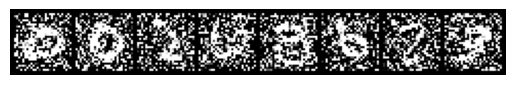

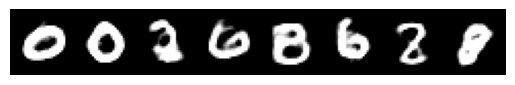

In [ ]:
test(MNIST_test, MNIST_denoise, noise=2)

## Oxford-IIIT Pets

In [ ]:
# Segmentation maps (detecting the pet in an image)
def segment_discrete(segment_map):
    discrete = (segment_map * 255)
    discrete[discrete == 3] = 2  # consider border of pet as background
    return discrete - 1  # so our classes are 0 and 1

pets_preprocess = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Resize((250,250))])

segmentation_preprocess = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Resize((250,250),
        interpolation = torchvision.transforms.InterpolationMode.NEAREST),
     torchvision.transforms.Lambda(segment_discrete)])

pets_train_set = torchvision.datasets.OxfordIIITPet(
    root='./data', split='trainval', download=True, target_types='segmentation',
    transform = pets_preprocess, target_transform = segmentation_preprocess)
print(pets_train_set)
print()
pets_test_set = torchvision.datasets.OxfordIIITPet(
    root='./data', split='test', download=True, target_types='segmentation',
    transform = pets_preprocess, target_transform = segmentation_preprocess)
print(pets_test_set)

100%|██████████| 791918971/791918971 [00:20<00:00, 39167905.84it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 14183994.62it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet
Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: ./data
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
           )
Target transform: Compose(
                      ToTensor()
                      Resize(size=(250, 250), interpolation=nearest, max_size=None, antialias=warn)
                      Lambda()
                  )

Dataset OxfordIIITPet
    Number of datapoints: 3669
    Root location: ./data
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
           )
Target transform: Compose(
                      ToTensor()
                      Resize(size=(250, 250), interpolation=nearest, max_size=None, antialias=warn)
                      Lambda()
              

In [ ]:
pets_test_loader = torch.utils.data.DataLoader(pets_test_set, 4, shuffle=True)
pets_test = iter(pets_test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


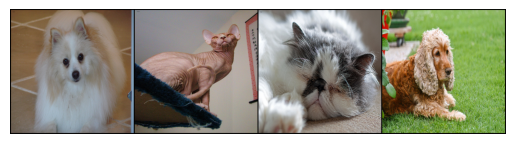

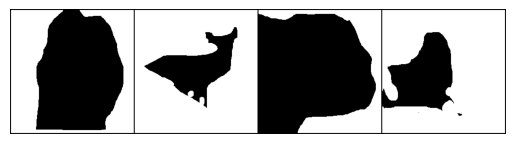

In [ ]:
images, segmentations = next(pets_test)
image_grid(images)
image_grid(segmentations)

In [ ]:
# Convolutional Autoencoder
class ConvAuto(nn.Module):
    def __init__(self):
        super(ConvAuto, self).__init__()
        self.conv_1 = nn.Conv2d(
            in_channels=3, out_channels=12, kernel_size=5, stride=3, padding=2)
        self.conv_2 = nn.Conv2d(12, 8, 3)
        self.conv_3 = nn.Conv2d(8, 4, 2, padding=1)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv_transpose_3 = nn.ConvTranspose2d(4, 8, 2, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv_transpose_2 = nn.ConvTranspose2d(8, 12, 3)
        self.conv_transpose_1 = nn.ConvTranspose2d(12, 3, 5, 3, 2)

# ~ Threefold reduction in dimensionality
class ConvCompress(ConvAuto):
    def forward(self, x):
        a = F.relu(self.conv_1(x))
        a = F.relu(self.conv_2(a))
        a = F.relu(self.conv_transpose_2(a))
        a = self.conv_transpose_1(a)
        return a


class ConvNoise(ConvAuto):
    def forward(self, x):
        a = F.relu(self.conv_1(x))
        a = F.relu(self.conv_2(a))
        a = self.pool(a)[0]

        a = self.upsample(a)
        a = F.relu(self.conv_transpose_2(a))
        a = self.conv_transpose_1(a)
        return a


class ConvSegment(ConvAuto):
    def __init__(self):
        super(ConvSegment, self).__init__()
        self.conv_transpose_1 = nn.ConvTranspose2d(12, 1, 5, 3, 2)
        # 1 out channel for binary segmentation (pet or not)

    def forward(self, x):
        a = F.relu(self.conv_1(x))
        a = F.relu(self.conv_2(a))
        a = self.pool(a)[0]
        a = F.relu(self.conv_3(a))
        before, max_indices = self.pool(a)

        a = self.unpool(before, max_indices)
        a = F.relu(self.conv_transpose_3(a))
        a = self.upsample(a)
        a = F.relu(self.conv_transpose_2(a))
        a = F.relu(self.conv_transpose_1(a))
        return F.sigmoid(a)

In [ ]:
# Train compression autoencoder
# Compare original images with reconstructed images from compressed versions
pets_train_loader = torch.utils.data.DataLoader(
    pets_train_set, batch_size=32, shuffle=True)
pets_compress = ConvCompress()

optimizer = torch.optim.Adam(pets_compress.parameters(), lr=0.001)
train(pets_train_set, pets_train_loader, pets_compress, criterion, optimizer)

Device: cuda:0


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 1 training average loss: 0.058


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2 training average loss: 0.009


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 3 training average loss: 0.005


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 4 training average loss: 0.004


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 5 training average loss: 0.004


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 6 training average loss: 0.003


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 7 training average loss: 0.003


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 8 training average loss: 0.003


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 9 training average loss: 0.002


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 10 training average loss: 0.002


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


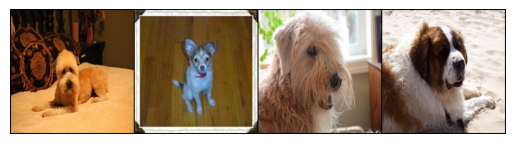

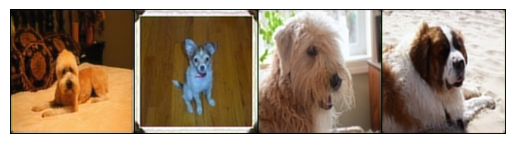

In [ ]:
test(pets_test, pets_compress)

In [ ]:
# Training denoising autoencoder
pets_noise = ConvNoise()
optimizer = torch.optim.Adam(pets_noise.parameters(), lr=0.001)
train(pets_train_set, pets_train_loader, pets_noise,
      criterion, optimizer, noise=0.5)

Device: cuda:0


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 1 training average loss: 0.046


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2 training average loss: 0.013


  0%|          | 0/115 [00:00<?, ?it/s]

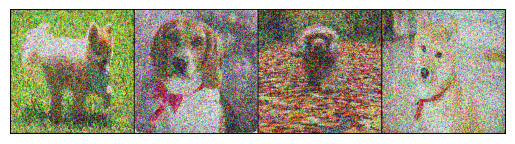

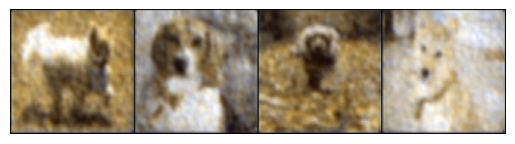

In [ ]:
test(pets_test, pets_noise, noise=0.5)

In [ ]:
# Segmentation. Identifying which pixels are part of the pet and which aren't
pets_segment = ConvSegment()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pets_segment.parameters(), lr=0.001)
train(pets_train_set, pets_train_loader, pets_segment,
      criterion, optimizer, compare_targets=True)  # targets segmentation maps

Device: cuda:0


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 1 training average loss: 0.625


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2 training average loss: 0.581


In [ ]:
test(pets_test, pets_segment)